<div style="border-bottom: 2px solid black; padding: 10px;">
    <h1 style="margin-bottom: 3px;">Machine Learning and business analytics</h1>
    <h3 style="margin-top: 0px; color: gray;">Sentiment analysis</h3>
    <p>Date: September 2, 2024</p>
</div>

- **Group:** Team Delta

# Dataset overview and preprocessing

## Sentiment analysis - Part 1 - Overview and preprocessing

### Requirements

- Python 3.10.12
- pandas
- numpy
- matplotlib
- scikitlearn
- langdetect/langid
- nltk

### Environment

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import csv
import matplotlib.pyplot as plt
from collections import Counter
from scipy.interpolate import interp1d
import re
from collections import Counter
import math
import langid
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

#### Constants and environment variables

In [2]:
training_file_path = f'../dataset/train.csv'
test_file_path = f'../dataset/test.csv'

TITLE_FONT_SIZE = 24
LABEL_FONT_SIZE = 20
AXIS_FONT_SIZE = 15
FIGURE_MAX_WIDTH = 8
FIGURE_MAX_HEIGHT = FIGURE_MAX_WIDTH*3/4

#### Helper functions

In [3]:
def is_english(text):
    try:
        lang, _ = langid.classify(text)
        return lang == 'en'
    except:
        return False

### Dataset information

The dataset is available free at:

- https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset

It contains premade training and test sets with: 27483 and 4816 *rows* respectively. They may contain empty rows or rows with null values.

Both the training and the test set contain field **sentiment** that characterizes the specific tweet.

### Loading the dataset

In [4]:
df_origin_training = pd.read_csv(training_file_path, encoding='ISO-8859-1')
df_origin_test = pd.read_csv(test_file_path, encoding='ISO-8859-1')

In [5]:
print("Training dataset dimensions : ", df_origin_training.shape)
print("Test     dataset dimensions : ", df_origin_test.shape)

print("Training dataset tweets     : ", df_origin_training.shape[0])
print("Test     dataset tweets     : ", df_origin_test.shape[0])
print("Total                       : ", df_origin_training.shape[0] + df_origin_test.shape[0])
print("Space dimensions            : ", df_origin_training.shape[1])


Training dataset dimensions :  (27481, 10)
Test     dataset dimensions :  (4815, 9)
Training dataset tweets     :  27481
Test     dataset tweets     :  4815
Total                       :  32296
Space dimensions            :  10


### Dataset overview

#### Inspecting attributes

The text column contains the original tweet. 

We are mostly interested in the *selected_text* column. This column contains the important words of a tweet. We are also interested in the sentiment column which contains the sentiment of the specific tweet. 

Other columns describe geographical information of the tweet and the user. 

The valid values for sentiment are:

- positive
- negative
- neutral

In [6]:
print(df_origin_training.dtypes)

textID               object
text                 object
selected_text        object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020      int64
Land Area (Km²)     float64
Density (P/Km²)       int64
dtype: object


In [7]:
print(df_origin_test.dtypes)

textID               object
text                 object
sentiment            object
Time of Tweet        object
Age of User          object
Country              object
Population -2020    float64
Land Area (Km²)     float64
Density (P/Km²)     float64
dtype: object


#### Tweet destribution

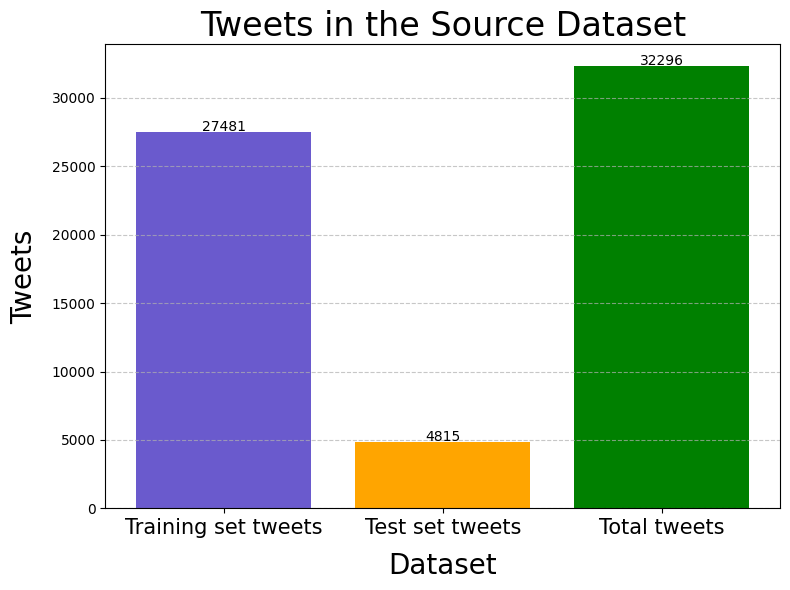

In [8]:
x = df_origin_training.shape[0] + df_origin_test.shape[0]

plt.figure(figsize=(FIGURE_MAX_WIDTH, FIGURE_MAX_HEIGHT))
plt.bar('Training set tweets', df_origin_training.shape[0], color='slateblue')
plt.text('Training set tweets', df_origin_training.shape[0] + 900,
         df_origin_training.shape[0], ha='center', va='top', rotation=0)

plt.bar('Test set tweets', df_origin_test.shape[0], color='orange')
plt.text('Test set tweets', df_origin_test.shape[0] + 900,
         df_origin_test.shape[0], ha='center', va='top', rotation=0)

plt.bar('Total tweets', x, color='green')
plt.text('Total tweets', x + 900, x, ha='center', va='top', rotation=0)

plt.xlabel('Dataset', fontsize=LABEL_FONT_SIZE, labelpad=10)
plt.ylabel('Tweets', fontsize=LABEL_FONT_SIZE, labelpad=10)
plt.title('Tweets in the Source Dataset', fontsize=TITLE_FONT_SIZE)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, ha='center', fontsize=AXIS_FONT_SIZE)
plt.tight_layout()
plt.show()

#### Sentiment distribution

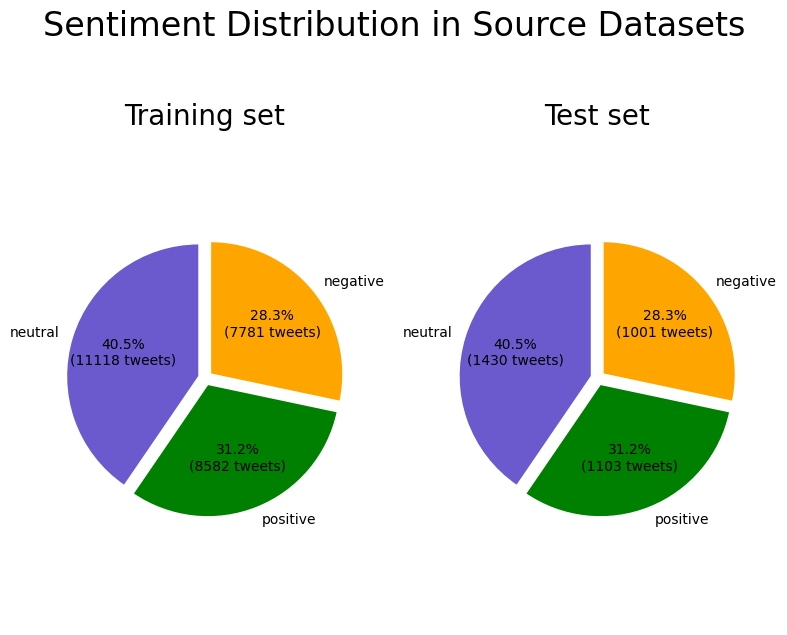

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(FIGURE_MAX_WIDTH, FIGURE_MAX_HEIGHT))
titles = ["Training set", "Test set"]
colors = ['slateblue', 'green','orange' ]
explode = (0.05, 0.05, 0.05)

for i, dataset in enumerate([df_origin_training, df_origin_test]):
    sentiment_freq = dataset['sentiment'].value_counts()

    # Create the pie chart
    wedges, texts, autotexts = axs[i].pie(
        sentiment_freq,
        labels=sentiment_freq.index,
        autopct=lambda p: '{:.1f}%\n({:.0f} tweets)'.format(p, p * sum(sentiment_freq) / 100),
        colors=colors[:len(sentiment_freq)],
        explode=explode[:len(sentiment_freq)],
        startangle=90,
        wedgeprops=dict(edgecolor='w')
    )

    # Set title and equal aspect ratio
    axs[i].set_title(titles[i], fontsize=LABEL_FONT_SIZE)
    axs[i].axis('equal')

    for autotext in autotexts:
        autotext.set_color('black')

# Add a global title
fig.suptitle('Sentiment Distribution in Source Datasets', fontsize=TITLE_FONT_SIZE, y=1.05)
plt.tight_layout()
plt.show()

Tweet distribution

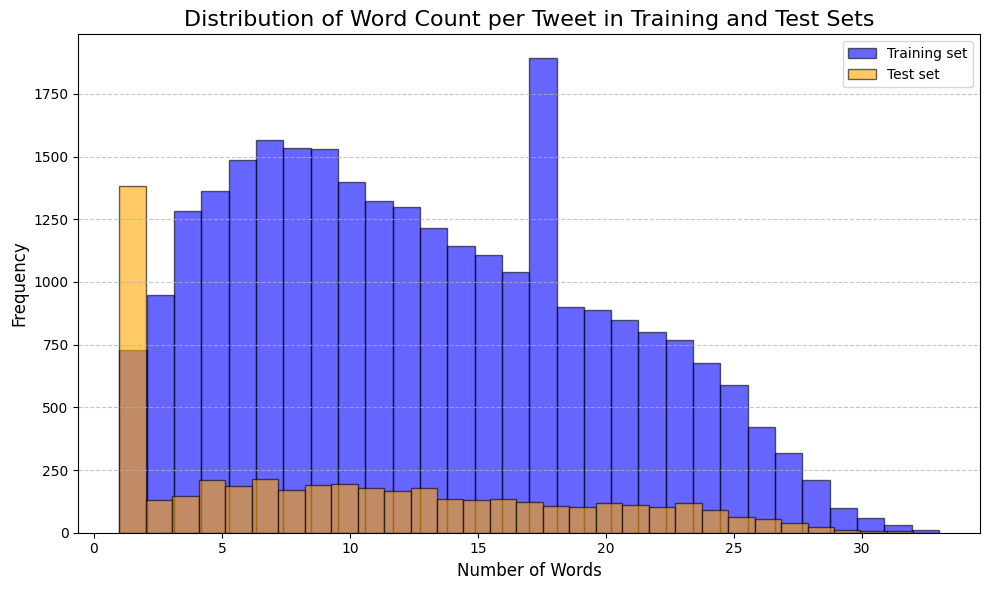

In [10]:
df_origin_training['text'] = df_origin_training['text'].astype(str)
df_origin_test['text'] = df_origin_test['text'].astype(str)

df_origin_training['word_count'] = df_origin_training['text'].apply(lambda x: len(x.split()))
df_origin_test['word_count'] = df_origin_test['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))

plt.hist(df_origin_training['word_count'], bins=30, color='blue', alpha=0.6, edgecolor='black', label='Training set')
plt.hist(df_origin_test['word_count'], bins=30, color='orange', alpha=0.6, edgecolor='black', label='Test set')

plt.title('Distribution of Word Count per Tweet in Training and Test Sets', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Preprocessing

#### Checking for null values

In [11]:
missing_values_training = df_origin_training.isnull().sum()

missing_values_test = df_origin_test.isnull().sum()

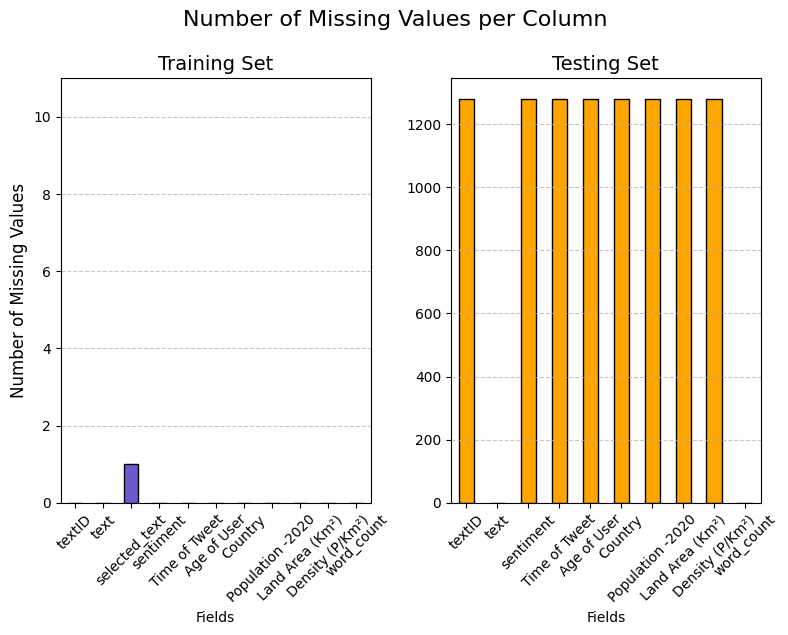

In [12]:
# Create subplots for both training and testing missing values
fig, axs = plt.subplots(1, 2, figsize=(FIGURE_MAX_WIDTH, FIGURE_MAX_HEIGHT))


missing_values_training.plot(kind='bar', ax=axs[0], color='slateblue', edgecolor='black')
axs[0].set_title('Training Set', fontsize=14)
axs[0].set_xlabel('Fields', fontsize=10)
axs[0].set_ylabel('Number of Missing Values', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_ylim(0, missing_values_training.max() + 10)

# Bar graph for the testing set
missing_values_test.plot(kind='bar', ax=axs[1], color='orange', edgecolor='black')
axs[1].set_title('Testing Set', fontsize=14)
axs[1].set_xlabel('Fields', fontsize=10)
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the combined plot
plt.tight_layout()
plt.suptitle('Number of Missing Values per Column', fontsize=16, y=1.05)
plt.show()

#### Cleaning up null values

In [13]:
df_training_cleaned = df_origin_training.dropna()
df_test_cleaned = df_origin_test.dropna()

df_training_cleaned.isnull().sum()
df_test_cleaned.isnull().sum()


textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
word_count          0
dtype: int64

In [14]:
print("Training dataset dimensions : ", df_training_cleaned.shape)
print("Test     dataset dimensions : ", df_test_cleaned.shape)

print("Training dataset tweets     : ", df_training_cleaned.shape[0])
print("Test     dataset tweets     : ", df_test_cleaned.shape[0])
print("Total                       : ", df_training_cleaned.shape[0] + df_test_cleaned.shape[0])
print("Space dimensions            : ", df_training_cleaned.shape[1])


Training dataset dimensions :  (27480, 11)
Test     dataset dimensions :  (3534, 10)
Training dataset tweets     :  27480
Test     dataset tweets     :  3534
Total                       :  31014
Space dimensions            :  11


#### Keep only english tweets

##### Filtering english language for training set

In [25]:
# Make a copy of the DataFrame to avoid warnings related to views vs. copies
df_training_cleaned = df_training_cleaned.copy()

# Apply the function and create a new column
df_training_cleaned['is_english'] = df_training_cleaned['text'].apply(is_english)

# Filter the DataFrame and drop the 'is_english' column
df_training_filtered = df_training_cleaned[df_training_cleaned['is_english']].drop(columns=['is_english'])


In [16]:
print("Before clean up: ")

print('-', df_training_cleaned.shape[0], 'tweets')

print("After clean up: ")

print('-', df_training_filtered.shape[0], 'tweets')

Before clean up: 
- 27480 tweets
After clean up: 
- 26319 tweets


##### Filtering english language for test set

In [17]:
# Make a copy of the DataFrame to avoid warnings related to views vs. copies
df_test_cleaned = df_test_cleaned.copy()

# Apply the function and create a new column
df_test_cleaned['is_english'] = df_test_cleaned['text'].apply(is_english)

# Filter the DataFrame and drop the 'is_english' column
df_test_filtered = df_test_cleaned[df_test_cleaned['is_english']].drop(columns=['is_english'])


Number of non-English entries: 159


In [18]:
print("Before clean up: ")

print('-', df_test_cleaned.shape[0], 'tweets')

print("After clean up: ")

print('-', df_test_filtered.shape[0], 'tweets')

Before clean up: 
- 3534 tweets
After clean up: 
- 3375 tweets


#### Removing unnecessary attributes

In [19]:
columns_of_interest = ['textID', 'text', 'sentiment']

df_training_filtered = df_training_filtered[columns_of_interest]

df_test_filtered = df_test_filtered[columns_of_interest]


### Filtered dataset overview

#### Tweet distribution

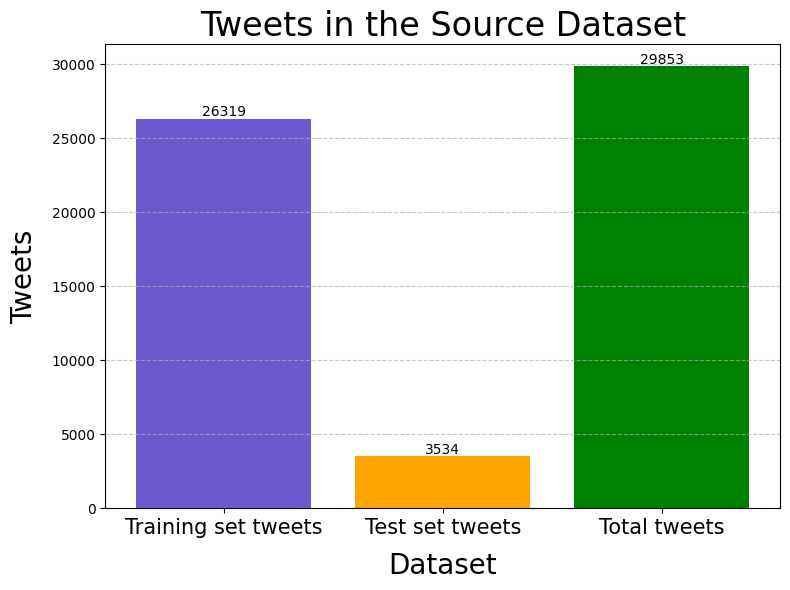

In [20]:
x = df_training_filtered.shape[0] + df_test_cleaned.shape[0]

plt.figure(figsize=(FIGURE_MAX_WIDTH, FIGURE_MAX_HEIGHT))
plt.bar('Training set tweets', df_training_filtered.shape[0], color='slateblue')
plt.text('Training set tweets', df_training_filtered.shape[0] + 900,
         df_training_filtered.shape[0], ha='center', va='top', rotation=0)

plt.bar('Test set tweets', df_test_cleaned.shape[0], color='orange')
plt.text('Test set tweets', df_test_cleaned.shape[0] + 900,
         df_test_cleaned.shape[0], ha='center', va='top', rotation=0)

plt.bar('Total tweets', x, color='green')
plt.text('Total tweets', x + 900, x, ha='center', va='top', rotation=0)

plt.xlabel('Dataset', fontsize=LABEL_FONT_SIZE, labelpad=10)
plt.ylabel('Tweets', fontsize=LABEL_FONT_SIZE, labelpad=10)
plt.title('Tweets in the Source Dataset', fontsize=TITLE_FONT_SIZE)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, ha='center', fontsize=AXIS_FONT_SIZE)
plt.tight_layout()
plt.show()

#### Sentiment distribution

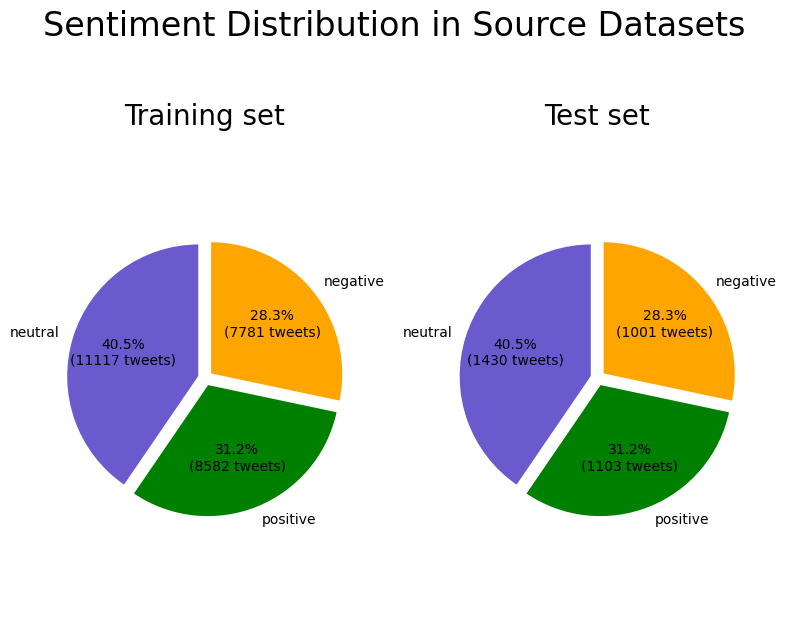

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(FIGURE_MAX_WIDTH, FIGURE_MAX_HEIGHT))
titles = ["Training set", "Test set"]
explode = (0.05, 0.05, 0.05)

for i, dataset in enumerate([df_training_cleaned, df_test_cleaned]):
    sentiment_freq = dataset['sentiment'].value_counts()

    # Create the pie chart
    wedges, texts, autotexts = axs[i].pie(
        sentiment_freq,
        labels=sentiment_freq.index,
        autopct=lambda p: '{:.1f}%\n({:.0f} tweets)'.format(p, p * sum(sentiment_freq) / 100),
        colors=colors[:len(sentiment_freq)],
        explode=explode[:len(sentiment_freq)],
        startangle=90,
        wedgeprops=dict(edgecolor='w')
    )


    axs[i].set_title(titles[i], fontsize=LABEL_FONT_SIZE)
    axs[i].axis('equal')
    for autotext in autotexts:
        autotext.set_color('black')

fig.suptitle('Sentiment Distribution in Source Datasets', fontsize=TITLE_FONT_SIZE, y=1.05)

plt.tight_layout()
plt.show()

#### Attributes of interest

In [22]:
df_training_filtered.dtypes

textID       object
text         object
sentiment    object
dtype: object

In [23]:
df_test_filtered.dtypes

textID       object
text         object
sentiment    object
dtype: object

### Save the preprocessed datasets to disk

In [24]:
df_training_filtered.to_csv('../dataset/preprocessed/df_training_preprocessed.csv', index=False)

df_test_filtered.to_csv('../dataset/preprocessed/df_test_preprocessed.csv', index=False)